https://towardsdatascience.com/using-deep-learning-ai-to-predict-the-stock-market-9399cf15a312

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd /content/drive/My Drive/Thesis/Thesissub/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Thesis/Thesissub


In [6]:

# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

import tensorflow as tf

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout



import pandas_datareader as pdr


In [7]:
df = pd.read_csv('cleaned_ETH.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# RUN

In [8]:
## Datetime conversion
df['date'] = pd.to_datetime(df.date)

# Setting the index
df = df.set_index('date')

df.head()


,close,lag_3,lower_band,MIDPOINT_15,MIDPOINT_30,SAR,SMA_5,NEW_SMA_5,SMA_7,SMA_30,trima_15,WMA_5,WMA_7,WMA_14,WMA_30,roll_var_5,roll_var_7,roll_var_14,roll_var_30,5 Day STD,7 Day STD,14 Day STD,30 Day STD,ADX_5,ADX_10,ADX_30,ADXR_10,APO,aroondown,aroonup,aroon_osc,BOP,CCI_30,CMO_10,DX_10,macd,macdsignal,macdhist,MINUS_DI_10,MINUS_DM_10,MOM_10,PLUS_DI_10,PLUS_DM_10,PPO,roc_5,roc_10,roc_30,rsi_5,rsi_10,rsi_30,slowk,slowd,fastk,fastd,fastk_rsi,fastd_rsi,TRIX_10,ULTOSC,WILLR,HT_DCPERIOD,HT_DCTREND
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-27,0.869641,0.563590,0.432947,0.652235,0.652235,1.39615,0.664049,0.664049,0.619325,0.610330,0.529684,0.719228,0.678987,0.603524,0.596478,0.018666,0.019485,0.012718,0.008137,0.136623,0.139590,0.112776,0.090208,58.970293,36.746349,31.069537,38.297876,-0.032645,40.0,100.0,60.0,0.849267,227.502281,49.054821,55.241774,-0.028652,-0.075500,0.046848,11.788948,0.114061,0.322463,40.889406,0.395616,-5.348770,53.186181,58.932021,20.642887,88.631801,74.527411,51.978621,86.415021,74.230857,94.022102,86.415021,100.00000,100.000000,-0.458187,62.485553,-5.977898,24.089428,0
2015-10-28,1.002480,0.616039,0.398295,0.718655,0.718655,1.39615,0.756613,0.756613,0.698632,0.624317,0.547184,0.832039,0.774776,0.661518,0.621778,0.032721,0.031685,0.025855,0.013212,0.180890,0.178003,0.160795,0.114943,64.999495,39.740526,30.599149,40.724075,0.001843,30.0,100.0,70.0,0.530555,308.521368,59.633347,66.688116,0.016200,-0.044933,0.061133,9.176230,0.102655,0.484746,45.916599,0.513673,0.295197,85.762445,93.628397,71.985614,92.179157,79.816674,56.112958,92.614056,84.727295,91.603322,92.614056,100.00000,100.000000,0.329190,69.541358,-8.396678,24.656104,0
2015-10-29,1.206660,0.731317,0.334606,0.820745,0.820745,1.39615,0.885227,0.885227,0.789912,0.642501,0.579054,0.982054,0.901783,0.742169,0.659349,0.053365,0.062123,0.051593,0.024517,0.231009,0.249244,0.227141,0.156579,70.484200,43.147588,30.428947,43.639467,0.055424,20.0,100.0,80.0,0.776787,362.299154,70.200825,73.811153,0.074291,-0.005192,0.079483,7.297054,0.092390,0.717646,48.429368,0.613175,8.626259,114.102460,146.753678,82.510377,95.110536,85.100412,61.397394,95.208474,91.412517,100.000000,95.208474,100.00000,100.000000,1.356837,75.799520,-0.000000,25.887397,0
2015-10-30,1.041220,0.869641,0.314420,0.820745,0.820745,1.39615,0.970264,0.970264,0.861564,0.652586,0.617623,1.034052,0.964610,0.794621,0.685072,0.032294,0.056221,0.061144,0.029575,0.179706,0.237109,0.247273,0.171974,75.263481,46.682561,30.485116,46.569007,0.105977,10.0,100.0,90.0,-0.445701,291.899471,37.737935,78.497318,0.098475,0.029364,0.069111,5.483426,0.083151,0.606391,45.518825,0.690248,16.239533,69.018518,139.455040,40.963704,68.939363,68.868967,55.768747,86.242242,91.354924,67.123405,86.242242,13.96221,71.320737,2.221777,63.811425,-32.876595,26.350540,0
2015-10-31,0.916627,1.002480,0.309084,0.820745,0.820745,1.39615,1.007326,1.007326,0.911998,0.660134,0.662430,1.016173,0.978376,0.825653,0.702107,0.017022,0.038961,0.063123,0.031871,0.130470,0.197385,0.251243,0.178525,73.763424,48.275674,30.349120,45.301852,0.145360,0.0,90.0,90.0,-0.831917,167.784720,18.780449,62.613685,0.101216,0.053315,0.047901,9.390366,0.142825,0.469298,40.843878,0.621223,22.019745,25.339218,104.911141,32.803112,54.755744,59.390224,52.051165,73.588319,85.013012,53.641551,73.588319,0.00000,37.987403,2.756076,57.125295,-46.363165,26.263933,1


In [9]:
## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['close']])

# Normalizing/Scaling the DF

scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

### Functions

In [10]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
  
  
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          
          
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

# Models

In [50]:
df.shape

(1765, 61)

In [101]:
# How many periods looking back to learn
n_per_in  = 750
# How many periods to predict
n_per_out = 2
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [52]:
X.shape

(1014, 750, 61)

In [119]:
## Creating the NN
patience=20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=2, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



## Fitting and Training
res = model.fit(X, y, epochs=1000, batch_size=128, validation_split=0.1, verbose=0, callbacks=[early_stopping])



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 750, 90)           54720     
_________________________________________________________________
lstm_68 (LSTM)               (None, 750, 30)           14520     
_________________________________________________________________
lstm_69 (LSTM)               (None, 750, 30)           7320      
_________________________________________________________________
lstm_70 (LSTM)               (None, 60)                21840     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 122       
Total params: 98,522
Trainable params: 98,522
Non-trainable params: 0
_________________________________________________________________


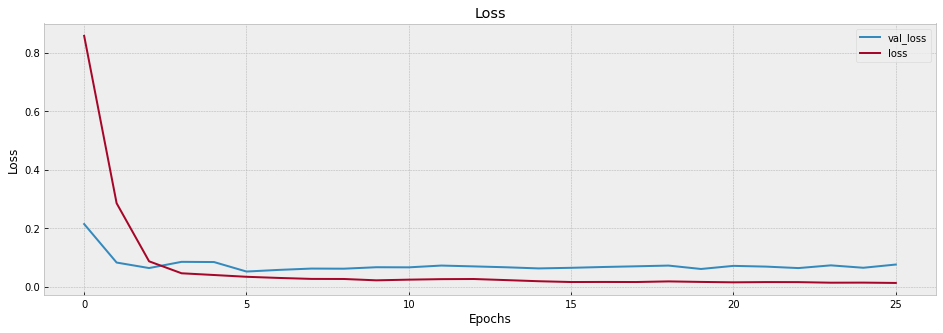

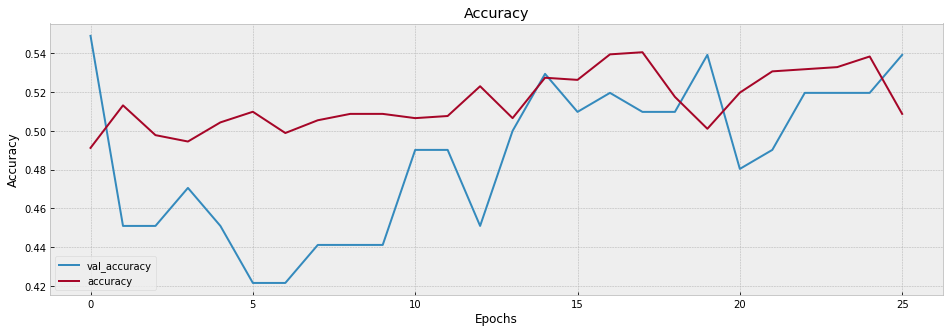

In [117]:
visualize_training_results(res)

In [118]:
score = model.evaluate(X, y, verbose=1)
score

32/32 [==============================] - 2s 63ms/step - loss: 0.0180 - accuracy: 0.5158


[0.017966844141483307, 0.5157790780067444]

In [113]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE

print("RMSE:", val_rmse(actual, predictions))

RMSE: 99.92815897680657


RMSE: 99.92815897680657


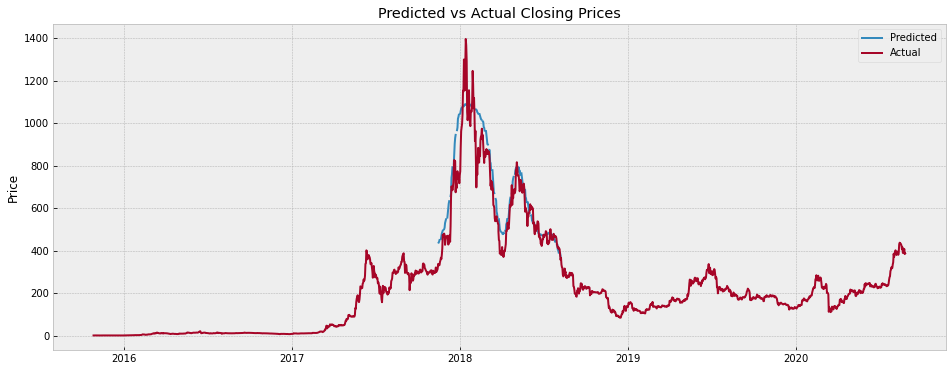

In [114]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE

print("RMSE:", val_rmse(actual, predictions))

            
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.xlim('10-2018', '10-2018')
plt.show()

In [85]:
actual.to_csv('actuals_LSTM_1_120_ETH.csv')
predictions.to_csv('predictions_LSTM_1_120_ETH.csv')

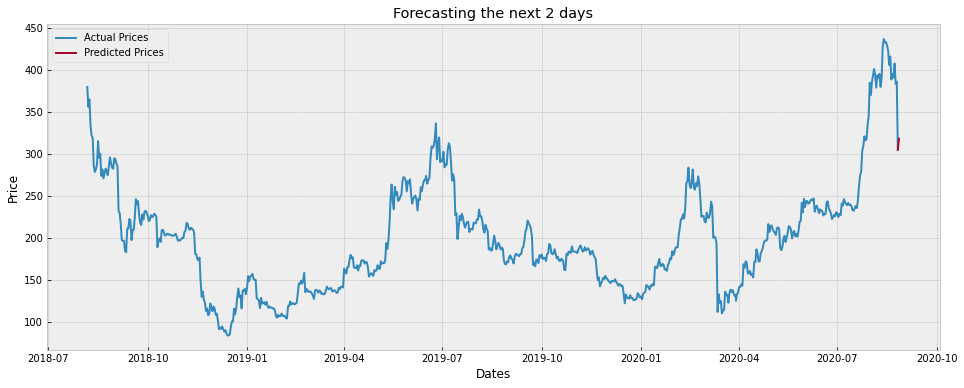

In [120]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))
'''
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))
'''
# Printing the predicted prices

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()

# TEST

# Models
5 day


In [60]:
df.shape

(1765, 61)

In [87]:
# How many periods looking back to learn
n_per_in  = 120
# How many periods to predict
n_per_out = 5
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [88]:
## Creating the NN
patience=20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=2, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



## Fitting and Training
res = model.fit(X, y, epochs=1000, batch_size=128, validation_split=0.1, verbose=0, callbacks=[early_stopping])



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 120, 90)           54720     
_________________________________________________________________
lstm_33 (LSTM)               (None, 120, 30)           14520     
_________________________________________________________________
lstm_34 (LSTM)               (None, 120, 30)           7320      
_________________________________________________________________
lstm_35 (LSTM)               (None, 60)                21840     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 305       
Total params: 98,705
Trainable params: 98,705
Non-trainable params: 0
_________________________________________________________________


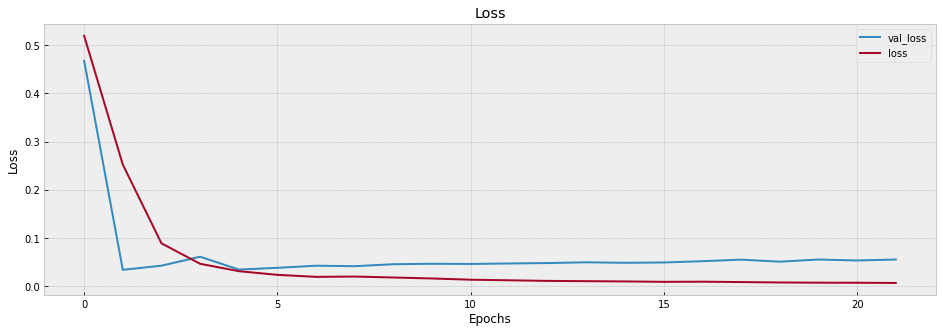

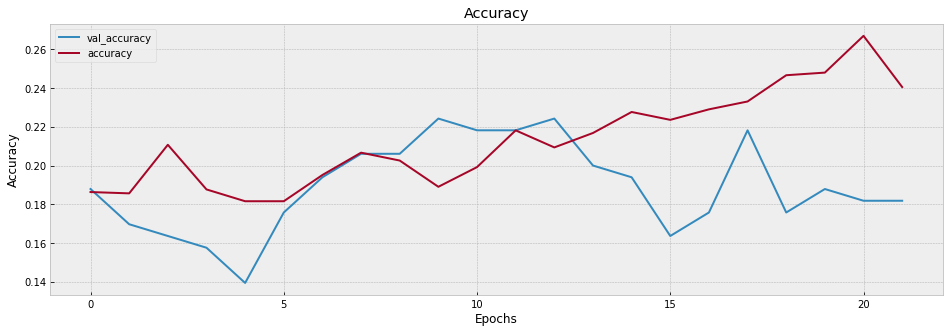

In [89]:
visualize_training_results(res)

In [90]:
score = model.evaluate(X, y, verbose=1)
score

52/52 [==============================] - 1s 10ms/step - loss: 0.0108 - accuracy: 0.2736


[0.010790207423269749, 0.27361366152763367]

RMSE: 25.80326125375544


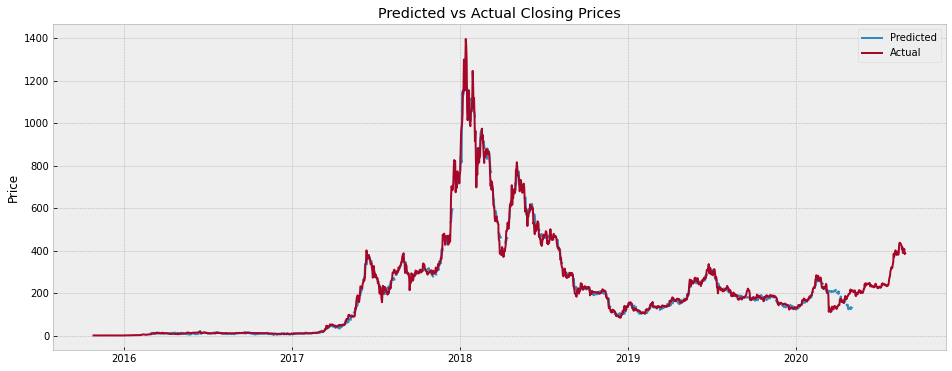

In [91]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE

print("RMSE:", val_rmse(actual, predictions))

            
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.xlim('10-2018', '10-2018')
plt.show()

In [92]:
actual.to_csv('actuals_LSTM_5_120_ETH.csv')
predictions.to_csv('predictions_LSTM_5_120_ETH.csv')

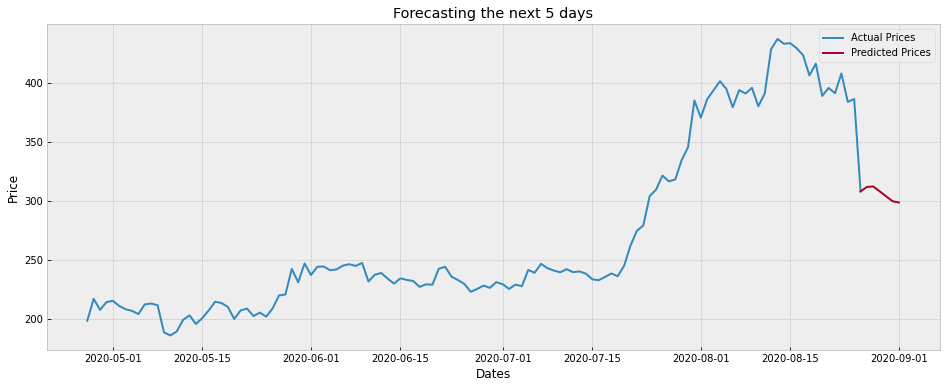

In [93]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))
'''
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))
'''
# Printing the predicted prices
#print(actual)


# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()

# Models
30

# Models

In [70]:
df.shape

(1765, 61)

In [94]:
# How many periods looking back to learn
n_per_in  = 120
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [72]:
X.shape

(986, 750, 61)

In [95]:
## Creating the NN
patience=20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=2, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



## Fitting and Training
res = model.fit(X, y, epochs=1000, batch_size=128, validation_split=0.1, verbose=0, callbacks=[early_stopping])



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 120, 90)           54720     
_________________________________________________________________
lstm_37 (LSTM)               (None, 120, 30)           14520     
_________________________________________________________________
lstm_38 (LSTM)               (None, 120, 30)           7320      
_________________________________________________________________
lstm_39 (LSTM)               (None, 60)                21840     
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1830      
Total params: 100,230
Trainable params: 100,230
Non-trainable params: 0
_________________________________________________________________


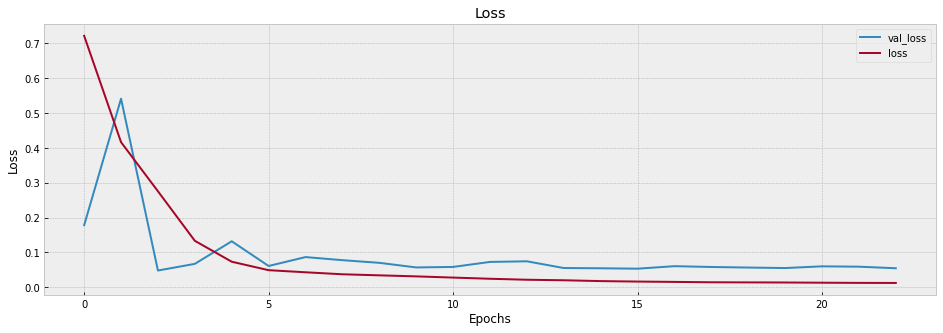

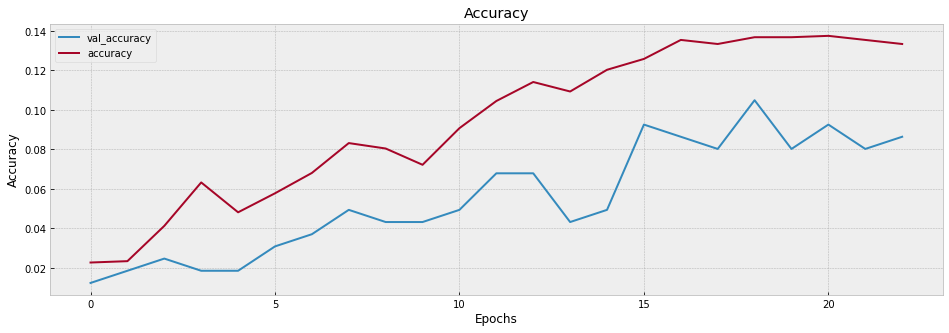

In [96]:
visualize_training_results(res)

In [97]:
score = model.evaluate(X, y, verbose=1)
score

51/51 [==============================] - 0s 10ms/step - loss: 0.0162 - accuracy: 0.1349


[0.016216041520237923, 0.1349009871482849]

RMSE: 51.66090173198766


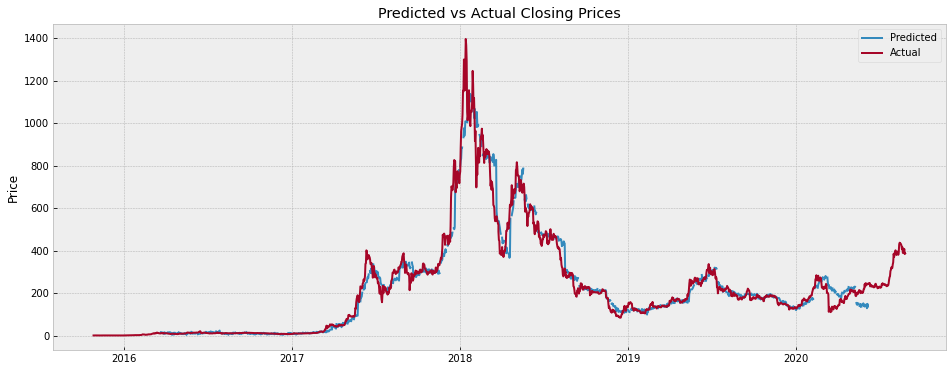

In [98]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE

print("RMSE:", val_rmse(actual, predictions))

            
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.xlim('10-2018', '10-2018')
plt.show()

In [77]:
predictions.tail()

,close
date,
2020-08-21,NaN
2020-08-22,NaN
2020-08-23,NaN
2020-08-24,NaN
2020-08-25,NaN


In [99]:
actual.to_csv('actuals_LSTM_30_120_ETH.csv')
predictions.to_csv('predictions_LSTM_30_120_ETH.csv')

                 close
2020-04-27  198.415390
2020-04-28  216.968231
2020-04-29  207.602051
2020-04-30  214.219101
2020-05-01  215.325378
...                ...
2020-08-22  391.384491
2020-08-23  408.144196
2020-08-24  384.001038
2020-08-25  386.466125
2020-08-26  471.749512

[121 rows x 1 columns]
                 close
2020-08-26  471.749512
2020-08-27  511.801025
2020-08-28  520.450623
2020-08-31  535.229370
2020-09-01  541.784790
2020-09-02  541.798584
2020-09-03  604.413879
2020-09-04  642.763428
2020-09-07  555.907471
2020-09-08  588.346008
2020-09-09  634.935120
2020-09-10  639.432373
2020-09-11  614.732788
2020-09-14  626.290405
2020-09-15  640.499817
2020-09-16  653.923950
2020-09-17  660.877258
2020-09-18  689.261475
2020-09-21  722.695679
2020-09-22  714.533325
2020-09-23  764.828674
2020-09-24  765.442322
2020-09-25  751.682617
2020-09-28  736.850708
2020-09-29  779.762573
2020-09-30  801.506897
2020-10-01  776.839661
2020-10-02  855.962280
2020-10-05  729.580688
2020-10-06

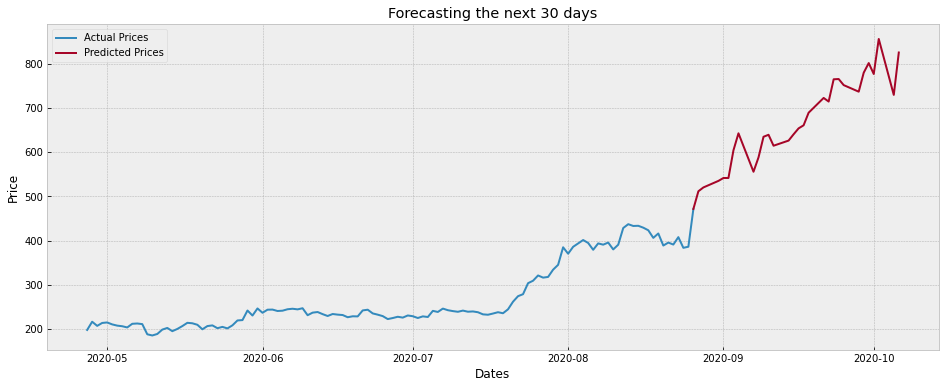

In [100]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))
'''
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))
'''
# Printing the predicted prices
print(actual)
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()

# Test 2

In [38]:
df = pd.read_csv('cleaned_BTC.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [39]:
df.head()

,date,close,ewm_15,dema_15,dema_30,kama_30,MIDPOINT_30,SMA_5,NEW_SMA_5,SMA_7,SMA_14,SMA_30,trima_15,trima_30,WMA_5,WMA_7,WMA_14,WMA_30,roll_var_5,roll_var_7,roll_var_14,roll_var_30,5 Day STD,7 Day STD,14 Day STD,30 Day STD,ADX_30,ADXR_10,APO,aroondown,aroonup,aroon_osc,BOP,CCI_30,CMO_10,DX_10,macd,macdsignal,macdhist,MINUS_DI_10,MINUS_DM_10,MOM_10,PLUS_DI_10,PLUS_DM_10,PPO,roc_5,roc_10,roc_30,rsi_5,rsi_10,rsi_30,slowk,slowd,fastk,fastd,fastk_rsi,fastd_rsi,TRIX_10,ULTOSC,HT_DCTREND
0,2015-10-27,293.787994,271.629333,285.840926,278.491969,271.804081,264.923996,284.183594,284.183594,280.173283,271.112430,255.391700,269.114207,253.015280,286.732259,284.183495,277.071457,264.416678,39.810603,78.454468,147.122420,298.676404,6.309564,8.857453,12.129403,17.282257,52.207865,73.887280,20.183901,10.0,100.0,90.0,0.768207,164.624712,68.439473,91.130297,16.896916,14.909358,1.987558,2.704814,1.911954,23.147980,58.285146,41.200058,7.903116,7.212892,8.553051,26.220904,90.688208,84.219737,73.965359,85.610001,87.970227,94.876216,85.610001,100.0,100.000000,0.788343,59.776054,0
1,2015-10-28,304.618011,275.754114,291.798038,282.844348,277.814699,270.339005,289.807996,289.807996,285.651284,274.871645,257.574234,271.957363,255.029959,293.543732,290.294677,281.538867,267.592569,89.884824,110.827748,190.128156,368.203072,9.480761,10.527476,13.788697,19.188618,53.029767,75.212461,22.298868,0.0,100.0,100.0,0.864350,183.951955,75.461194,92.964982,19.007926,16.275547,2.732379,2.256840,1.720758,42.975006,61.903346,47.199040,8.657259,10.170856,16.425054,27.379554,94.113822,87.730597,76.680817,91.435948,88.106067,96.844464,91.435948,100.0,100.000000,0.852532,67.204434,0
2,2015-10-29,313.855011,280.517936,298.724186,287.897298,285.697746,274.957504,296.248199,296.248199,291.341570,279.124146,260.146501,275.282065,257.259222,301.559403,297.345608,286.736650,271.223587,165.982334,183.090742,255.063569,455.539364,12.883413,13.531103,15.970710,21.343368,53.907498,76.667197,24.768401,0.0,100.0,100.0,0.583043,197.908817,79.734109,94.455808,21.484236,18.011777,3.472459,1.822650,1.548682,50.417999,63.927232,54.318156,9.520943,11.432829,19.138541,32.603403,95.772057,89.867054,78.645970,95.001366,90.682438,93.283418,95.001366,100.0,100.000000,0.937347,67.081892,0
3,2015-10-30,328.015015,286.456389,307.582187,294.195490,296.043782,282.654007,305.115204,305.115204,298.701429,283.777433,263.211668,279.106112,259.731789,312.148342,306.513969,293.255432,275.602200,280.495306,307.320405,395.290010,584.646884,16.747994,17.530556,19.881902,24.179472,54.846155,78.043375,27.558434,0.0,100.0,100.0,0.695636,221.118290,84.369889,95.794109,24.788577,20.270710,4.517867,1.440101,1.393814,58.552002,67.040102,64.885333,10.470066,15.628533,21.729142,38.954087,97.254275,92.184944,81.163318,93.914261,93.450525,91.614901,93.914261,100.0,100.000000,1.050927,72.930028,0
4,2015-10-31,314.165985,289.920762,311.437492,298.118668,298.819618,282.654007,310.888403,310.888403,303.346000,286.886431,265.765568,283.172251,262.342010,315.165269,310.380108,297.307239,278.889576,161.151480,273.575926,442.640024,644.719215,12.694545,16.540131,21.039012,25.391322,55.521533,78.711301,29.793933,0.0,90.0,90.0,-0.609794,176.850864,47.663359,81.525001,25.402411,21.981277,3.421134,5.372189,5.943428,47.893982,52.784123,58.396800,11.210607,10.117770,17.986864,32.253131,68.076779,73.831679,72.514310,85.881092,91.598906,72.744956,85.881092,0.0,66.666667,1.129560,60.408944,1


In [40]:
df.iloc[:,1:60]

,close,ewm_15,dema_15,dema_30,kama_30,MIDPOINT_30,SMA_5,NEW_SMA_5,SMA_7,SMA_14,SMA_30,trima_15,trima_30,WMA_5,WMA_7,WMA_14,WMA_30,roll_var_5,roll_var_7,roll_var_14,roll_var_30,5 Day STD,7 Day STD,14 Day STD,30 Day STD,ADX_30,ADXR_10,APO,aroondown,aroonup,aroon_osc,BOP,CCI_30,CMO_10,DX_10,macd,macdsignal,macdhist,MINUS_DI_10,MINUS_DM_10,MOM_10,PLUS_DI_10,PLUS_DM_10,PPO,roc_5,roc_10,roc_30,rsi_5,rsi_10,rsi_30,slowk,slowd,fastk,fastd,fastk_rsi,fastd_rsi,TRIX_10,ULTOSC,HT_DCTREND
0,293.787994,271.629333,285.840926,278.491969,271.804081,264.923996,284.183594,284.183594,280.173283,271.112430,255.391700,269.114207,253.015280,286.732259,284.183495,277.071457,264.416678,39.810603,78.454468,147.122420,298.676404,6.309564,8.857453,12.129403,17.282257,52.207865,73.887280,20.183901,10.0,100.0,90.0,0.768207,164.624712,68.439473,91.130297,16.896916,14.909358,1.987558,2.704814,1.911954,23.147980,58.285146,41.200058,7.903116,7.212892,8.553051,26.220904,90.688208,84.219737,73.965359,85.610001,87.970227,94.876216,85.610001,100.000000,100.000000,0.788343,59.776054,0
1,304.618011,275.754114,291.798038,282.844348,277.814699,270.339005,289.807996,289.807996,285.651284,274.871645,257.574234,271.957363,255.029959,293.543732,290.294677,281.538867,267.592569,89.884824,110.827748,190.128156,368.203072,9.480761,10.527476,13.788697,19.188618,53.029767,75.212461,22.298868,0.0,100.0,100.0,0.864350,183.951955,75.461194,92.964982,19.007926,16.275547,2.732379,2.256840,1.720758,42.975006,61.903346,47.199040,8.657259,10.170856,16.425054,27.379554,94.113822,87.730597,76.680817,91.435948,88.106067,96.844464,91.435948,100.000000,100.000000,0.852532,67.204434,0
2,313.855011,280.517936,298.724186,287.897298,285.697746,274.957504,296.248199,296.248199,291.341570,279.124146,260.146501,275.282065,257.259222,301.559403,297.345608,286.736650,271.223587,165.982334,183.090742,255.063569,455.539364,12.883413,13.531103,15.970710,21.343368,53.907498,76.667197,24.768401,0.0,100.0,100.0,0.583043,197.908817,79.734109,94.455808,21.484236,18.011777,3.472459,1.822650,1.548682,50.417999,63.927232,54.318156,9.520943,11.432829,19.138541,32.603403,95.772057,89.867054,78.645970,95.001366,90.682438,93.283418,95.001366,100.000000,100.000000,0.937347,67.081892,0
3,328.015015,286.456389,307.582187,294.195490,296.043782,282.654007,305.115204,305.115204,298.701429,283.777433,263.211668,279.106112,259.731789,312.148342,306.513969,293.255432,275.602200,280.495306,307.320405,395.290010,584.646884,16.747994,17.530556,19.881902,24.179472,54.846155,78.043375,27.558434,0.0,100.0,100.0,0.695636,221.118290,84.369889,95.794109,24.788577,20.270710,4.517867,1.440101,1.393814,58.552002,67.040102,64.885333,10.470066,15.628533,21.729142,38.954087,97.254275,92.184944,81.163318,93.914261,93.450525,91.614901,93.914261,100.000000,100.000000,1.050927,72.930028,0
4,314.165985,289.920762,311.437492,298.118668,298.819618,282.654007,310.888403,310.888403,303.346000,286.886431,265.765568,283.172251,262.342010,315.165269,310.380108,297.307239,278.889576,161.151480,273.575926,442.640024,644.719215,12.694545,16.540131,21.039012,25.391322,55.521533,78.711301,29.793933,0.0,90.0,90.0,-0.609794,176.850864,47.663359,81.525001,25.402411,21.981277,3.421134,5.372189,5.943428,47.893982,52.784123,58.396800,11.210607,10.117770,17.986864,32.253131,68.076779,73.831679,72.514310,85.881092,91.598906,72.744956,85.881092,0.000000,66.666667,1.129560,60.408944,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,11681.825195,11684.390997,11988.589182,12057.263636,11678.265684,10895.647461,11780.440625,11780.440625,11864.201311,11786.959054,11336.612891,11821.662537,11514.731531,11728.133268,11790.286203,11810.199591,11656.879471,24891.458015,47953.339649,41478.028567,544300.759121,157.770270,218.982510,203.661554,737.767415,32.168561,54.604042,510.19

In [41]:
future_predict = 5
df['future'] = df['close'].shift(-future_predict)

df.head()

df= df.dropna()

In [ ]:
df.iloc[:,60]

In [ ]:
input_cols = df.iloc[:,1:60]
len(input_cols)

In [ ]:
# Put your inputs into a single list
df['single_input_vector'] = df.iloc[:,1:60].apply(tuple, axis=1).apply(list)
# Double-encapsulate list so that you can sum it in the next step and keep time steps as separate elements
df['single_input_vector'] = df.single_input_vector.apply(lambda x: [list(x)])
# Use .cumsum() to include previous row vectors in the current row list of vectors
df['cumulative_input_vectors'] = df.single_input_vector.cumsum()

In [ ]:
# If your output is multi-dimensional, you need to capture those dimensions in one object
# If your output is a single dimension, this step may be unnecessary
#df['output_vector'] = df['future'].apply(tuple, axis=1).apply(list)

In [ ]:
# Pad your sequences so they are the same length
from keras.preprocessing.sequence import pad_sequences

max_sequence_length = df.cumulative_input_vectors.apply(len).max()
# Save it as a list   
padded_sequences = pad_sequences(df.cumulative_input_vectors.tolist(), max_sequence_length).tolist()
df['padded_input_vectors'] = pd.Series(padded_sequences).apply(np.asarray)

In [ ]:
input_cols.shape[1]

In [ ]:
# Extract your training data
X_train_init = np.asarray(df.padded_input_vectors)
# Use hstack to and reshape to make the inputs a 3d vector
X_train = np.hstack(X_train_init).reshape(len(df),max_sequence_length,input_cols.shape[1])
y_train = np.hstack(np.asarray(df.future)).reshape(len(df),1)

In [ ]:
y_train.shape

In [ ]:
print(X_train_init.shape)

In [ ]:
print(X_train.shape)

In [ ]:
# Get your input dimensions
# Input length is the length for one input sequence (i.e. the number of rows for your sample)
# Input dim is the number of dimensions in one input vector (i.e. number of input columns)
input_length = X_train.shape[1]
input_dim = X_train.shape[2]
# Output dimensions is the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])

In [ ]:
len(y_train[0])

In [ ]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

# Build the model
model = Sequential()

# I arbitrarily picked the output dimensions as 4
model.add(LSTM(4, input_dim = input_dim, input_length = input_length))
# The max output value is > 1 so relu is used as final activation.
model.add(Dense(output_dim, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
'''
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

model.add(LSTM(4, input_dim = input_dim, input_length = input_length))




# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



## Fitting and Training
res = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, verbose=0)
'''

In [ ]:
# Set batch_size to 7 to show that it doesn't have to be a factor or multiple of your sample size
history = model.fit(X_train, y_train,
              batch_size=34, epochs=100, validation_split=0.1,
              verbose = 1)


## Fitting and Training
#res = model.fit(X, y, epochs=1000, batch_size=128, validation_split=0.1, verbose=0)

In [ ]:
visualize_training_results(history)

In [ ]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE

print("RMSE:", val_rmse(actual, predictions))

            
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.xlim('10-2018', '10-2018')
plt.show()

In [ ]:
df.shape

(1765, 61)

In [ ]:
# How many periods looking back to learn
n_per_in  = 1500
# How many periods to predict
n_per_out = 2
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [ ]:
X.shape

(764, 1000, 61)

In [ ]:
## Creating the NN
patience=20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=2, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



## Fitting and Training
res = model.fit(X, y, epochs=1000, batch_size=128, validation_split=0.1, verbose=0, callbacks=[early_stopping])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1500, 90)          54720     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1500, 30)          14520     
_________________________________________________________________
lstm_6 (LSTM)                (None, 1500, 30)          7320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 122       
Total params: 98,522
Trainable params: 98,522
Non-trainable params: 0
_________________________________________________________________


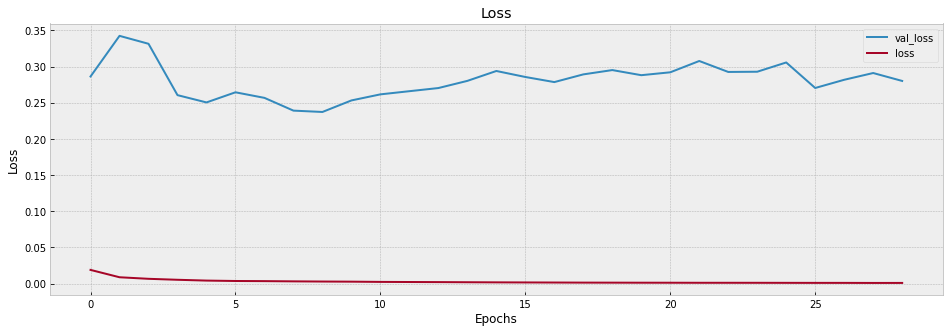

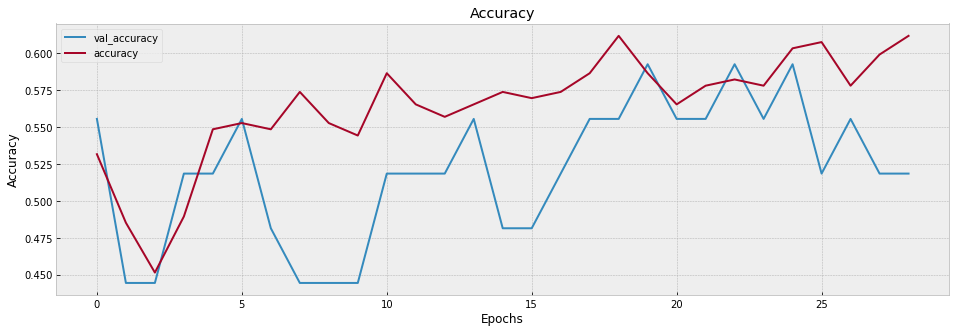

In [ ]:
visualize_training_results(res)

In [ ]:
score = model.evaluate(X, y, verbose=1)
score

9/9 [==============================] - 1s 84ms/step - loss: 0.0294 - accuracy: 0.5947


[0.029446236789226532, 0.5946969985961914]

RMSE: nan


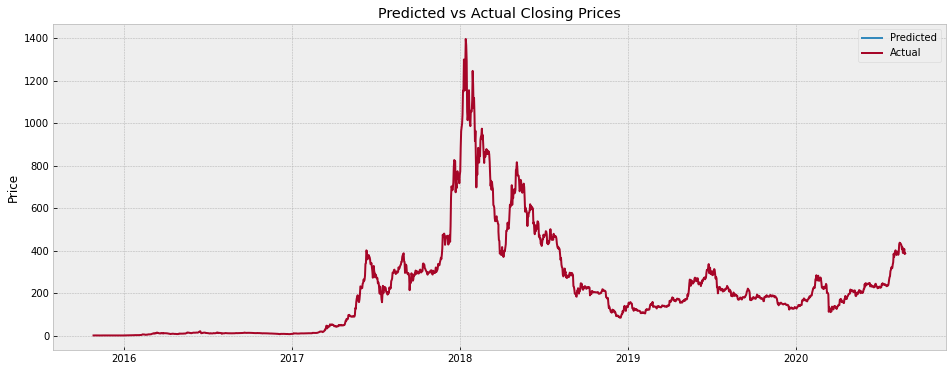

In [ ]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE

print("RMSE:", val_rmse(actual, predictions))

            
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.xlim('10-2018', '10-2018')
plt.show()

In [ ]:
predictions.tail()

,close
date,
2020-08-21,NaN
2020-08-22,NaN
2020-08-23,NaN
2020-08-24,NaN
2020-08-25,NaN


In [ ]:
actual.to_csv('actuals_LSTM_5_ETH.csv')
predictions.to_csv('predictions_LSTM_5_ETH.csv')

                 close
2016-07-17   11.034400
2016-07-18   11.619100
2016-07-19   12.450600
2016-07-20   12.650700
2016-07-21   14.661900
...                ...
2020-08-22  391.384491
2020-08-23  408.144196
2020-08-24  384.001038
2020-08-25  386.466125
2020-08-26  230.749252

[1501 rows x 1 columns]
                 close
2020-08-26  230.749252
2020-08-27  239.321442


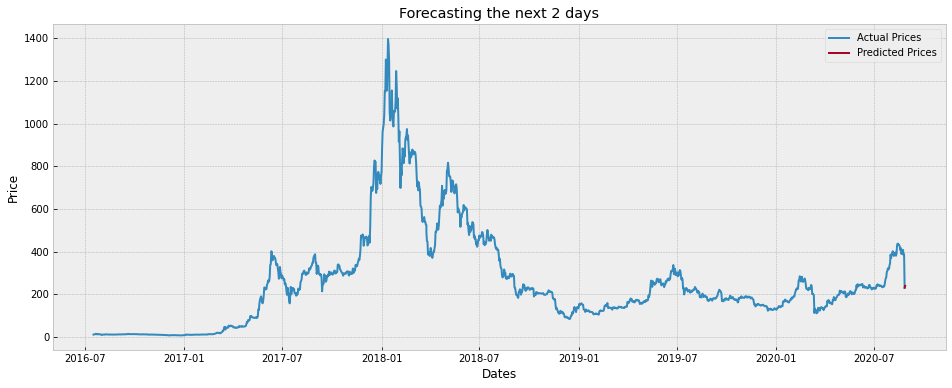

In [ ]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))
'''
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))
'''
# Printing the predicted prices
print(actual)
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()

# Test 3

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split

In [1]:
df = pd.read_csv('cleaned_BTC.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.drop(['date'], axis=1)

NameError: ignored

In [ ]:

future_predict = 5
df['future'] = df['close'].shift(-future_predict)


df = df.dropna()
#df = df.reset_index()
#df = df.drop(['date'], axis=1)
X = df.drop(['future'], axis=1)
y = df['future']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False )


In [ ]:
X.shape

In [ ]:
#X_test = X_test.reshape(528, 59 ,1)

In [ ]:
#X_train = X_train.reshape(1232, 59,1)

In [ ]:
X_test.shape

In [ ]:
batch_size = 32
state_size = 8

max_features = 59
maxlen = 59
embedding_size = 128
epochs_no = 20
unique_tokens = unique_tokens

In [ ]:
model = Sequential()

model.add(SimpleRNN(state_size,return_sequences=True))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

In [ ]:

model = Sequential()
model.add(LSTM(50, input_shape=(59,1)))
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


## Fitting and Training
res = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.1, verbose=0)


In [ ]:
model.summary()

In [ ]:
visualize_training_results(res)

In [ ]:

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

model.add(LSTM(59, input_shape=(1, 59)))

# Final Hidden layer
model.add(LSTM(52, activation=activ))

# Output layer
model.add(Dense(1))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



## Fitting and Training
res = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.1, verbose=0)


In [ ]:
visualize_training_results(res)